In [1]:
__author__ = 'Elliot I. Simon'
__email__ = 'ellsim@dtu.dk'
__version__ = 'October 01, 2021'

The purpose of this script is to assist Globe data users in working with NetCDF files from the WindCube scanning lidars.

In [3]:
# Required modules. If not installed, run $ pip install modulename
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import os
import glob
import xarray as xr
from netCDF4 import Dataset
from netCDF4 import MFDataset

In [4]:
# Select between static and interactive plotting
%matplotlib inline
#%matplotlib notebook

In [5]:
# Formatting options
pd.set_option('display.float_format', lambda x: '%.6f' % x)
plt.rcParams['figure.figsize'] = [15, 10]

In [6]:
# Get list of files
filenames=[]
position = 'Globe7_NO-08'
path = r"M:\Documents\GloBE\Azimuth_alignment_turbines\Azimuth_orientation_PPI\Globe7\*.nc"
for file in glob.glob(path):
    filenames.append(file)
print(filenames)

['M:\\Documents\\GloBE\\Azimuth_alignment_turbines\\Azimuth_orientation_PPI\\Globe7\\Globe7_WCS000231_2021-08-17_15-48-55_ppi_1034_150m.nc']


In [7]:
# Process all data
alldata = []
for f in filenames:
    #print(f)

    # Get sweep id from metadata
    rootgrp = Dataset(f, "r", format="NETCDF4")
    group = list(rootgrp.groups.keys())[-1]
    # Open netcdf file inside specific sweep group, append to alldata list
    alldata.append(xr.open_dataset(f, group=group, decode_times=False))
    
    # Make export path
    outpath = path.split('*')[0]

In [8]:
# Only look at one file for this example
alldata = alldata[0]

In [16]:
# Show Dataset parameters
alldata

<xarray.Dataset>
Dimensions:                      (range: 159, time: 360)
Coordinates:
  * time                         (time) float64 1.629e+09 ... 1.629e+09
  * range                        (range) int32 400 440 480 ... 6640 6680 6720
Data variables: (12/21)
    scan_file                    |S1408 ...
    settings_file                |S8928 ...
    res_file                     |S6144 ...
    ray_angle_resolution         float64 ...
    range_gate_length            float64 ...
    ray_accumulation_time        int32 ...
    ...                           ...
    gate_index                   (range) float64 ...
    radial_wind_speed            (time, range) float64 -8.37 -8.3 ... -8.95
    radial_wind_speed_ci         (time, range) float64 99.72 99.72 ... 99.64
    radial_wind_speed_status     (time, range) float32 ...
    doppler_spectrum_width       (time, range) float64 ...
    doppler_spectrum_mean_error  (time, range) float64 ...
Attributes:
    scan_file_name:      PPI
    scan_id:             1034
    settings_file_name:  default320
    settings_id:         17
    res_file_name:       150m
    res_id:              94

In [73]:
# Don't use timestamp, use time! (timestamp has bugs sometimes)
# Here is how to convert to datetime64 format
dt = pd.to_datetime(np.array(alldata['time']), unit='s', origin='unix')
print(dt)

DatetimeIndex(['2021-08-17 15:48:55.628000', '2021-08-17 15:48:56.628000',
               '2021-08-17 15:48:57.628000', '2021-08-17 15:48:58.628000',
               '2021-08-17 15:48:59.628000', '2021-08-17 15:49:00.628000',
               '2021-08-17 15:49:01.628000', '2021-08-17 15:49:02.628000',
               '2021-08-17 15:49:03.628000', '2021-08-17 15:49:04.628000',
               ...
               '2021-08-17 15:54:45.628000', '2021-08-17 15:54:46.628000',
               '2021-08-17 15:54:47.628000', '2021-08-17 15:54:48.628000',
               '2021-08-17 15:54:49.628000', '2021-08-17 15:54:50.628000',
               '2021-08-17 15:54:51.628000', '2021-08-17 15:54:52.628000',
               '2021-08-17 15:54:53.628000', '2021-08-17 15:54:54.628000'],
              dtype='datetime64[ns]', length=360, freq=None)


Text(0.5, 1.0, 'Globe7_NO-08')

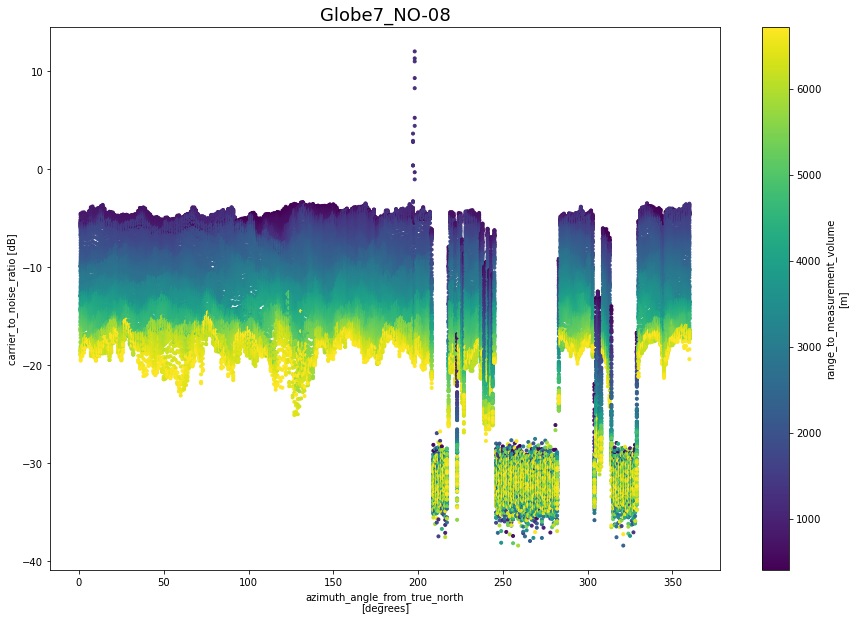

In [10]:
# Plot CNR against Azimuth angle, colored by range
# This scan is a 360 degree PPI used to map the visible wind turbine(s)
# Areas with low CNR are blocked by objects. High CNR is the turbine tower being mapped. The other areas are wind measurements.

alldata.plot.scatter('azimuth', 'cnr', hue='range', marker='.')
plt.title(str(position), fontsize=18);

Text(0.5, 1.0, 'Globe7_NO-08')

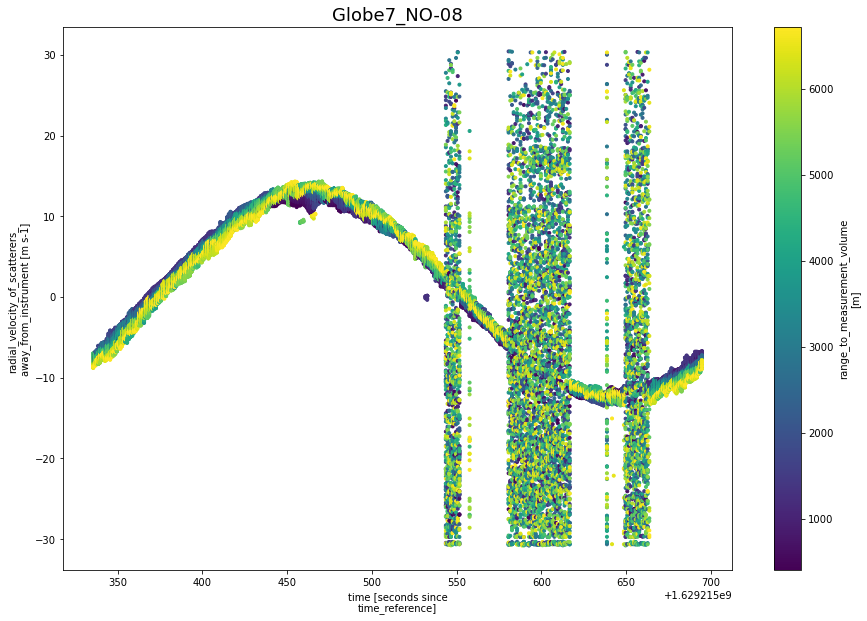

In [11]:
#Plot Radial wind speed by time
alldata.plot.scatter('time', 'radial_wind_speed', hue='range', marker='.')
plt.title(str(position), fontsize=18)

In [83]:
# If you prefer working with 2D data, i.e. Pandas DataFrames

# Select one range gate and give a 2D pandas DataFrame
df = alldata.sel(range=400)[['time', 'azimuth', 'elevation', 'cnr', 'radial_wind_speed', 'radial_wind_speed_ci']].to_dataframe()
del df['range']
# Format the datetime index (we generated this above)
df.set_index(dt, inplace=True)

In [82]:
df

,azimuth,elevation,cnr,radial_wind_speed,radial_wind_speed_ci
2021-08-17 15:48:55.628,0.982000,4.000000,-5.420000,-8.370000,99.716200
2021-08-17 15:48:56.628,1.980000,4.000000,-5.320000,-8.180000,99.722500
2021-08-17 15:48:57.628,2.979000,4.000000,-5.320000,-7.990000,99.725000
2021-08-17 15:48:58.628,3.977000,4.000000,-5.540000,-7.800000,99.711700
2021-08-17 15:48:59.628,4.981000,4.000000,-5.620000,-7.600000,99.714600
...,...,...,...,...,...
2021-08-17 15:54:50.628,355.975000,4.001000,-4.440000,-7.710000,99.685500
2021-08-17 15:54:51.628,356.976000,3.999000,-4.270000,-7.540000,99.682200
2021-08-17 15:54:52.628,357.976000,4.001000,-4.360000,-7.380000,99.653000
2021-08-17 15:54:53.628,358.972000,4.000000,-4.400000,-7.250000,99.678100


In [86]:
# Filtering comes next, e.g. a threshold on radial_speed_ci
df_filt = df.loc[df['radial_wind_speed_ci'] > 95]

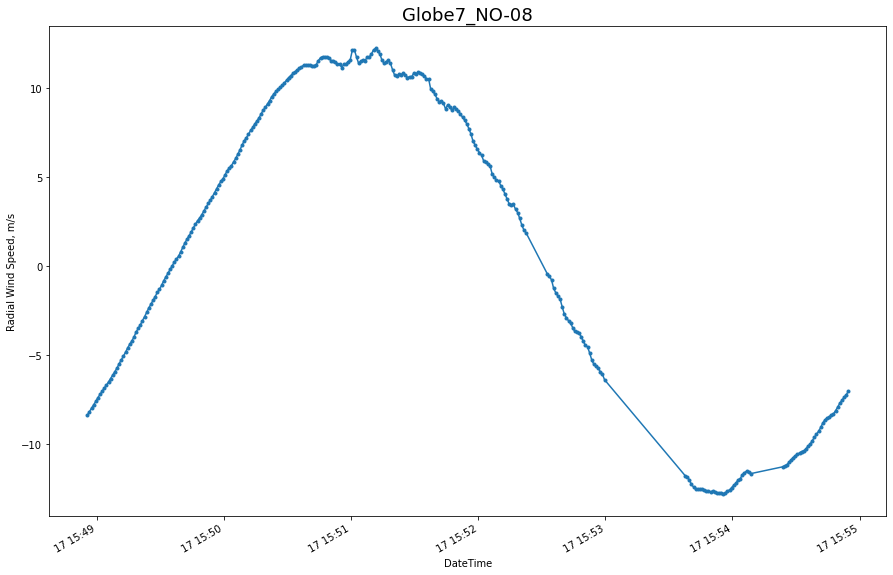

In [87]:
# Plotting example using Pandas DataFrame
df_filt['radial_wind_speed'].plot(marker='.')
plt.ylabel('Radial Wind Speed, m/s')
plt.xlabel('DateTime')
plt.title(str(position), fontsize=18);

Etc. Etc.

Please contact Elliot Simon <ellsim@dtu.dk> if you require further assistance.